In [1]:
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
config = {
    "binary": False,
    "representations": "bow",
    "rep_params": {
        "max_features": 10000,                      # tamanho máximo de vocabulário
        "ngram_range": (1, 3),                      # ngrams 
    }
}

# Carregando dados de análise

In [3]:
train_df = pd.read_csv("/home/kenzosaki/mestrado/data/tweetsentbr/tweetsentbr_train.csv", index_col=0)
test_df = pd.read_csv("/home/kenzosaki/mestrado/data/tweetsentbr/tweetsentbr_test.csv", index_col=0)

In [4]:
# Para focar a análise em apenas duas classes: positivo e negativo
if config["binary"]:
    train_df = train_df[train_df["label"] != 0]
    test_df = test_df[test_df["label"] != 0]

In [5]:
train_df.head()

,label,text
5689,1,Simplesmente magnífica @fbbreal no Video Show ...
5386,1,"Saiu, mas saiu ahazando. Master Chef BR"
869,1,Já tô pronta pro Master Chef BR
5432,1,Muito amor por é o tchan Altas Horas
24,1,QUE PROGRAMA INCRÍVEL O @SBTTheNoite FEZ HOJE!...


# Definindo procedimento de pre-processamento de texto

Pipeline simples de pre-processamento de texto, incluindo: conversão para lower-case, remoção de stop-words, remoção de hashtags e lemmatização.

In [6]:
import spacy
nlp = spacy.load("pt_core_news_md")

In [7]:
from typing import Iterable

def apply_preprocessing_pipeline(text: str) -> Iterable[str]:

    tokens = nlp(text)
    final_tokens = []

    for token in tokens:

        lemma = token.lemma_

        if token.is_stop: continue              # remoção de stop-words
        if token.is_punct: continue             # remoção de pontuação
        if len(lemma.strip()) == 0: continue    # ignorar tokens "vazios"
        if "@" in lemma: continue               # remoção simples de hashtags

        final_tokens.append(lemma.lower())
    
    return final_tokens

# Conversão dos textos para representações esparsas

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
params = {
    "max_features": 10000,                      # tamanho máximo de vocabulário
    "ngram_range": (1, 3),                      # ngrams 
    "tokenizer": apply_preprocessing_pipeline   # pipeline de pre processamento pelo spacy
}

In [10]:
rep = config["representations"]
params = config["rep_params"]
vectorizer = CountVectorizer(**params, tokenizer=apply_preprocessing_pipeline) if rep == "bow" else TfidfVectorizer(**params, tokenizer=apply_preprocessing_pipeline)
vectorizer

CountVectorizer(max_features=10000, ngram_range=(1, 3),
                tokenizer=<function apply_preprocessing_pipeline at 0x7fd80d9197a0>)

In [11]:
X_train = vectorizer.fit_transform(train_df["text"].values)
X_test = vectorizer.transform(test_df["text"].values)

y_train = train_df["label"].values
y_test = test_df["label"].values

In [12]:
X_train.shape

(9849, 10000)

In [13]:
vectorizer.get_feature_names()[:10]

['$', "'s", '+', '1', '1 globo', '1 globo esporte', '17', '1h', '2', '30']

# Preparando classificadores

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [15]:
models = {
    "MLP": MLPClassifier(max_iter=500, early_stopping=True),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "SVC": SVC(),
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(n_estimators=100)
}

# Avaliando classificadores

In [16]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [17]:
def get_metrics(y_real, y_pred):

    metrics_dict = classification_report(y_real, y_pred, output_dict=True)

    return {
        "accuracy": metrics_dict["accuracy"],
        "precision": metrics_dict["macro avg"]["precision"],
        "recall": metrics_dict["macro avg"]["recall"],
        "f1": metrics_dict["macro avg"]["f1-score"]
    }


In [18]:
results_df = pd.DataFrame()

In [19]:
for model_name, model in tqdm(models.items(), desc="- Evaluating"):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results_dict = get_metrics(y_test, y_pred)
    results_dict["model"] = model_name
    results_df = results_df.append(results_dict, ignore_index=True)

- Evaluating: 100%|██████████| 5/5 [00:32<00:00,  6.48s/it]


In [20]:
results_df

,accuracy,precision,recall,f1,model
0,0.629720,0.607888,0.588157,0.592367,MLP
1,0.457978,0.468947,0.436261,0.419693,KNN
2,0.614292,0.587491,0.567110,0.563512,SVC
3,0.561104,0.535076,0.532006,0.533007,DT
4,0.609419,0.584303,0.574433,0.577214,RF


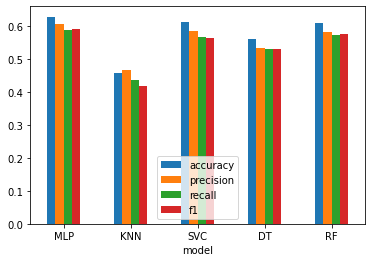

In [21]:
results_df.set_index("model").plot.bar(rot=0)